In [1]:
import sys
sys.path.append("../")
from utils import transform_image_to_kspace, transform_kspace_to_image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pydicom
from scipy import ndimage
import random
from gstools import SRF, Gaussian
from scipy.fftpack import dct, idct
import os
from sklearn.metrics import mean_squared_error
from sewar.full_ref import vifp
import time

import warnings
warnings.filterwarnings("ignore")
#C:\Users\Simone\anaconda3\envs\drs\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: 
#UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). 
#It's recommended that you change the 'Bits Stored' value warnings.warn(

In [2]:
data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'
#data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'
#data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis\Pelvis_2233,MP Pelvis_2233,MP\CT.2.25.168430369902691384448665480955143203741.dcm"

# bad pelvic image
# data_path = r'D:\Pelvis_2.2\Pelvis_2007,MP Pelvis_2007,MP\CT.2.25.100798620482803196971009051256598065467.dcm'
# data_path = r'D:\Pelvis_2.2\Pelvis_2004,MP Pelvis_2004,MP\CT.2.25.105465283217417927063669461408587264131.dcm'

data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

In [3]:
anatomy = ''
if data_path[0] == 'C':
    anatomy = 'brain'
elif data_path[0] == 'D':
    anatomy = 'pelvis'
print(anatomy)

brain


In [4]:
# functions for downsample

def cartesian_mask(factor, PE_direction, distribution):
    acceleration, center_fraction = factor
    size = 320
    mask = np.zeros((size, size), dtype=bool)
    num_cols = size
    num_low_frequencies = round(num_cols * center_fraction)
       
    if (distribution == "uniform"):
        adjusted_accel = round((acceleration * (num_low_frequencies - num_cols)) / (num_low_frequencies * acceleration - num_cols))
        offset = np.random.randint(0, round(adjusted_accel))
        accel_samples = np.arange(offset, num_cols - 1, adjusted_accel)
        accel_samples = np.around(accel_samples).astype(np.uint)
    elif (distribution == "random"):
        prob = (num_cols / acceleration - num_low_frequencies) / (num_cols - num_low_frequencies)
        accel_samples = np.random.uniform(size=num_cols) < prob
    
    if (PE_direction == "LR"):
        mask[:, round((num_cols - num_low_frequencies - 2) / 2):round((num_cols + num_low_frequencies - 2) / 2)] = True
        mask[:, accel_samples] = True
    elif (PE_direction == "AP"):
        mask[round((num_cols - num_low_frequencies - 2) / 2):round((num_cols + num_low_frequencies - 2) / 2), :] = True
        mask[accel_samples, :] = True
 
    return mask

In [5]:
# functions for motion

def c2h(X):
    # convert cartesian to homogeneous coordinates
    
    n = np.ones([1,X.shape[1]])
    Xh = np.concatenate((X,n))

    return Xh

def t2h(T, t):
    # convert a 2D transformation matrix and 2D translation vector to homogeneous transformation matrix

    T1 = np.concatenate((T, t[:,None]), axis=1)
    n = np.zeros([1, T1.shape[1]])
    n[-1,-1] = 1
    Th = np.concatenate((T1, n), axis=0)
    
    return Th

def rotate(phi):
    # create a 2D rotation matrix
    
    T = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]])
    
    return T

def image_transform(image, Th):
    # image transformation by inverse mapping

    # spatial coordinates of the transformed image
    x = np.arange(0, image.shape[1])
    y = np.arange(0, image.shape[0])
    xx, yy = np.meshgrid(x, y)

    # convert to a 2-by-p matrix (p is the number of pixels)
    X = np.concatenate((xx.reshape((1, xx.size)), yy.reshape((1, yy.size))))
    # convert to homogeneous coordinates
    Xh = c2h(X)

    # perform inverse coordinates mapping
    T_inv = np.linalg.pinv(Th)
    Xt = T_inv.dot(Xh) 
    image_t = ndimage.map_coordinates(image, [Xt[1,:], Xt[0,:]], order=3, mode='constant', cval=0.0).reshape(image.shape)

    return image_t

def combining_transforms(image, ang_deg, trans_x, trans_y):

    # rotation around the image center
    ang_rad = np.deg2rad(ang_deg)
    T_1 = t2h(np.eye(2), np.array([int(image.shape[1]/2), int(image.shape[0]/2)]))
    T_2 = t2h(rotate(ang_rad), np.zeros(2))
    T_3 = t2h(np.eye(2), np.array([-int(image.shape[1]/2), -int(image.shape[0]/2)]))
    T_rot = T_1.dot(T_2).dot(T_3)

    # translation
    T_trans = t2h(np.eye(2), np.array([trans_x, trans_y]))
    
    # combine transforms
    T_tot = T_trans.dot(T_rot)
    
    image_t = image_transform(image, T_tot)
    
    return image_t

def rigid_motion(image, pe_direction, n_movements, ang_std, trans_std):
    # normalize the image from 0 to 1
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # phase encoding direction
    if (pe_direction == "LR"):
        grid_size = image.shape[1]
    elif (pe_direction == "AP"):
        grid_size = image.shape[0]
    
    # locations of the movements
    corrupt_pct_range = np.random.uniform(0, 0.3*(100/(100-7))) #little over 30 %, because centre part will be masked
    corrupt_lines = np.maximum(n_movements, round(corrupt_pct_range*grid_size))
    clean_lines = grid_size - corrupt_lines
    locs_corrupt = np.sort(np.append(np.random.permutation(corrupt_lines)[:(n_movements)], (0, corrupt_lines)))
    locs_clean = np.sort(np.append(np.random.permutation(clean_lines)[:(n_movements)], (0, clean_lines)))
    locs = [0]
    seg = 0
    for i in range(n_movements):
        seg += locs_clean[i+1] - locs_clean[i]
        locs.append(seg)
        seg += locs_corrupt[i+1] - locs_corrupt[i]
        locs.append(seg)
    
    # rotation and translation parameters
    ang = np.random.normal(0, ang_std, n_movements)
    trans_x = np.random.normal(0, trans_std, n_movements)
    trans_y = np.random.normal(0, trans_std, n_movements)

    # combine kspaces
    kspace_clean = transform_image_to_kspace(image)
    kspace = np.copy(kspace_clean)
    for i in range(n_movements):
        img_i = combining_transforms(image, ang[i], trans_x[i], trans_y[i])
        kspace_i = transform_image_to_kspace(img_i)
        if (pe_direction == "LR"):
            kspace[:, locs[i*2+1]:locs[i*2+2]] = kspace_i[:, locs[i*2+1]:locs[i*2+2]]
        elif (pe_direction == "AP"):
            kspace[locs[i*2+1]:locs[i*2+2], :] = kspace_i[locs[i*2+1]:locs[i*2+2], :]
    
    # mask centre
    pct = 0.07 # percentage center k-space without motion
    num_low_frequencies = round(pct*grid_size) # lines center k-space without motion
    begin = round(grid_size/2-num_low_frequencies/2)
    end = round(grid_size/2+num_low_frequencies/2)
    if (pe_direction == "LR"):
        kspace[:, begin:end] = kspace_clean[:, begin:end]
    elif (pe_direction == "AP"):
        kspace[begin:end, :] = kspace_clean[begin:end, :]
    
    return kspace

def periodic_motion(kspace):
    x = np.linspace(-np.pi, np.pi, kspace.shape[1])
    y = np.linspace(-np.pi, np.pi, kspace.shape[0])
    kx, ky = np.meshgrid(x, y)

    # parameters
    alpha = np.random.uniform(0.1, 5) # respiratory frequency
    delta = np.random.uniform(0, 20) # shift along PE direction
    beta = np.random.uniform(0, np.pi/4) # phase
    ky0 = np.random.uniform(np.pi/10, np.pi/2) # center K-space lines without phase shift errors
    
    # phase error outside of center
    phase_error = ky*delta*np.sin(alpha*ky + beta)
    
    # no motion in the center of k-space
    phase_error[abs(ky) < ky0] = 0

    # add phase error to k-space
    kspace = kspace*np.exp(-1j*phase_error)

    return kspace

In [6]:
# functions for bias

# 2D discrete cosine transform
def dct2(grid):   
    # discrete cosine transform
    M = grid.shape[0]
    N = grid.shape[1]
    a = np.empty([M,M],float)
    b = np.empty([M,M],float)
    for i in range(M):
        a[i,:] = dct(grid[i,:], norm='ortho')
    for j in range(N):
        b[:,j] = dct(a[:,j], norm='ortho')
    
    # keep essential DCT coefficients
    b = b[:M, :N]
    
    # inverse discrete cosine transform
    m = b.shape[0]
    n = b.shape[1]
    M = 320
    N = 320
    a = np.empty([m,N],float)
    grid = np.empty([M,N],float)
    for i in range(m):
        a[i,:] = idct(b[i,:], n=M, norm='ortho')
    for j in range(N):
        grid[:,j] = idct(a[:,j], n=N, norm='ortho')
        
    return grid

def GetFields(image):    
    down_size = np.int32(np.divide(image.shape, 10))
    x = np.arange(down_size[0])
    y = np.arange(down_size[1])
    
    len_scale = np.random.uniform(10, 50)
    model = Gaussian(dim=2, var=50, len_scale=len_scale)

    srf = SRF(model)

    grid_z = srf((x, y), mesh_type='structured')
    grid_z = dct2(grid_z)
    
    bias_rng = np.random.uniform(0.20, 1.00)
    grid_z = np.interp(grid_z, (grid_z.min(), grid_z.max()),
                       (1 - bias_rng / 2, 1 + bias_rng / 2))
    
    return grid_z

In [7]:
# corrupt function

def corrupt(image, case, anatomy):
    kspace = transform_image_to_kspace(image)
    
    if case == "noise":
        signal_to_noise = np.random.uniform(0, 10)
        mean_signal = np.mean(np.abs(kspace))
        std_noise = mean_signal / 10**(signal_to_noise / 20)
        noise = np.random.normal(0, std_noise, size=np.shape(kspace)) + 1j*np.random.normal(0, std_noise, size=np.shape(kspace))
        kspace += noise
    
    elif case == "downsample":
        #acceleration, center_fraction = random.choice([(2, 0.16), (3, 0.12), (4, 0.08)])
        #mask = cartesian_mask((acceleration, center_fraction), random.choice(["LR", "AP"]), random.choice(["uniform", "random"]))  
        mask = cartesian_mask(random.choice([(2, 0.16), (3, 0.12), (4, 0.08)]), random.choice(["LR", "AP"]), random.choice(["uniform", "random"]))  
        kspace = np.where(mask, kspace, (0 + 0j))
        
    elif case == "motion":
        if anatomy == "brain":
            motion_type = "rigid"
        elif anatomy == "pelvis":
            motion_type = random.choice(["rigid", "periodic"])
        
        if (motion_type == "rigid"):
            kspace = rigid_motion(image, random.choice(["LR", "AP"]), np.random.randint(1,9), 3, 10)
        elif (motion_type == "periodic"):
            kspace = periodic_motion(kspace)
            
    elif case == "bias":
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        bias = GetFields(image)
        img = np.multiply(image, bias)
        kspace = transform_image_to_kspace(img)
      
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)
    return img

(-0.5, 319.5, 319.5, -0.5)

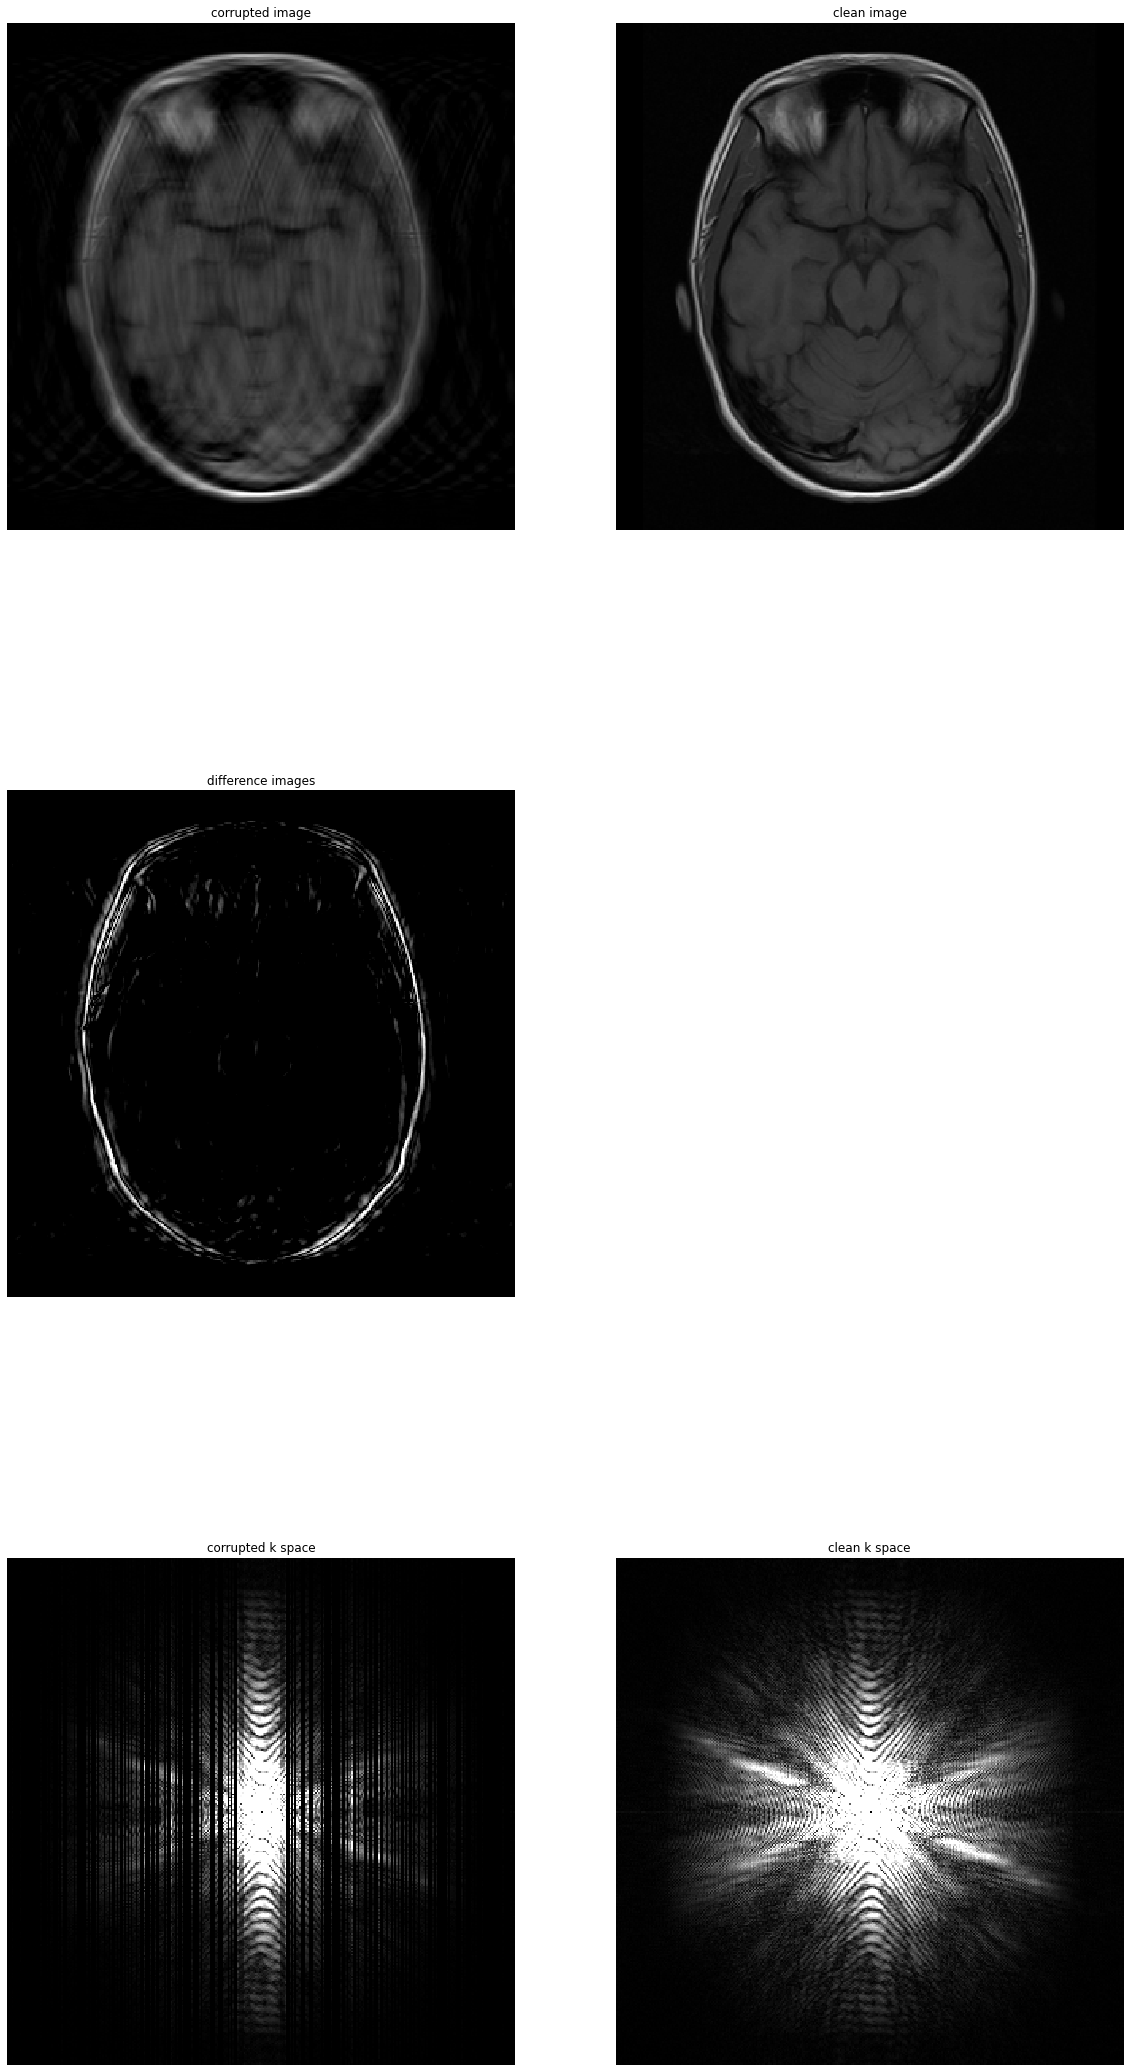

In [8]:
# plotting

img = corrupt(image, "downsample", anatomy)

hr = image
lr = img

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0.5, vmax=1 / 0.5)
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')

In [9]:
print(np.min(image), np.mean(image), np.std(image), np.max(image))
print(np.min(img), np.mean(img), np.std(img), np.max(img))

-0.8580642090420407 2.2204460492503132e-17 1.0 7.198928552992595
-1.5269697519573164 2.2204460492503132e-17 1.0 7.951121160547074


In [10]:
mean_squared_error(image, img)

0.11634063409054873

In [11]:
# the artefacts should be well-balanced in terms of MSE

images_path_list = []
#main_path_brain = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM'
#main_path_pelvis = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis2'
main_path_brain = r'C:\from SSD\fastMRI_brain_DICOM'
#main_path_pelvis = r'D:\Pelvis_2.2'

folders_brain = os.listdir(main_path_brain)
#folders_pelvis = os.listdir(main_path_pelvis)

for folder in folders_brain:
    folder_path = main_path_brain + '/' + folder
    images = os.listdir(folder_path)
    for image in images:
        image_path = folder_path + '/' + image
        images_path_list.append(image_path)
#for folder in folders_pelvis:
#    folder_path = main_path_pelvis + '/' + folder
#    images = os.listdir(folder_path)
#    for image in images:
#        image_path = folder_path + '/' + image
#        images_path_list.append(image_path)
print(len(images_path_list))

370490


In [12]:
mse_total = []
vif_total = []

batch = np.arange(len(images_path_list))
np.random.shuffle(batch)
batch = batch[: int((len(images_path_list))/100)]

#progress = np.linspace(0, len(images_path_list), 100, dtype=int)
progress = np.linspace(0, len(batch), 100, dtype=int)
i = 0
j = 0

start = time.time()

#for image_path in images_path_list:
for number in batch: 
    image_path = images_path_list[number]
    data = pydicom.dcmread(image_path)
    image = data.pixel_array   
    if (np.shape(image) != (320, 320)):
        image = cv2.resize(image, (320, 320))  
        
    i += 1
    if i in progress:
        j += 1
        print(j)
    
    anatomy = ''
    if image_path[0] == 'C':
        anatomy = 'brain'
    elif image_path[0] == 'D':
        anatomy = 'pelvis'
        
    if np.max(image) - np.min(image) > 1e-5:
#        for i in range(1):
        image = (image - np.mean(image)) / np.std(image)

        img_corrupt = corrupt(image, "downsample", anatomy)
        
        mse_image = mean_squared_error(image, img_corrupt)
        mse_total.append(mse_image)
        
        vif_image = vifp(image, img_corrupt)
        vif_total.append(vif_image)

finish = time.time()
print('duration in minutes: {}'.format((finish-start)/60))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
duration in minutes: 16.94730708996455


In [13]:
print(np.mean(mse_total), np.std(mse_total))

0.036872011019766365 0.046655985445808755


In [14]:
print(np.mean(vif_total), np.std(vif_total))

0.7572085922255519 0.14571147888254865


In [15]:
# 419615 total images; 370490 brain images and 49125 pelvic images

In [16]:
# downsampling; 0.0375570958468009 0.04501319454569181
# noise; 0.013395303365171387 0.01663437687945586
# bias; 0.01635979534630765 0.01504083005725115
# rigid motion; 0.044875805437717936 0.0730877109502793 duration in minutes: 45.93093680540721
# periodic motion; 0.041425382610951994 0.03653770888204221 duration in minutes: 15.816170608997345

In [17]:
# with batch = 3704 of brain: (with batch = 4196 of brain and pelvis:)
# downsampling
# 0.036872011019766365 0.046655985445808755 (mse: 0.03729156744663087 0.04459184111857123)
# 0.7572085922255519 0.14571147888254865 (vif: 0.7476947942353565 0.1480669198706125)
# duration in minutes: 16.94730708996455 (duration in minutes: 19.104584070046744)

# with batch = 4196 of brain and pelvis:
# motion
# mse: 0.01777186392132196 0.03282469563449429
# vif: 0.9089129994398338 0.11102643682285941
# duration in minutes: 24.82284971475601

# noise
# 0.013687013877267291 0.017992418697827826
# 0.9842239634161636 0.020080549850124835
# duration in minutes: 19.394452889760334

# bias
# 0.01853729400027626 0.020846161469736866
# 0.9923610567679247 0.029842309164620617
# duration in minutes: 22.865527498722077

In [18]:
len(batch)

3704